In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE
import lightgbm as lgb


from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
import pickle

In [2]:
data=pd.read_excel("data.xlsx")
data.head()

,Client,Unnamed: 1,Unnamed: 2,Contract,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Scoring,...,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Collection,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Computed
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CNP,Gender,Age,DataSemnarii,DataInchis,Number,Produs,CreditLimit,State,scoringdate,...,PenguinIgnoringBNR,DolphinIgnoringBNR,ClientCategory,Comission,Withdrawed,DpdDiffDaysMax,DpdTotal,PaidTotal,FutureTotal,IsDerrogationBNR
2,1900226063350,M,32,2021-10-15 18:37:54,2021-10-16 18:11:03,DK53851057,Penguin,1900,Inchis,2021-10-15 00:31:13,...,0,0,0,0,-1900,-27,0,1907.56,0,NaN
3,1900226063350,M,32,2021-11-06 03:38:12,2021-12-10 12:29:02,TC42768422,Penguin,700,Inchis,2021-10-15 00:31:13,...,0,0,0,0,-700,-22,0,783.58,0,NaN
4,1811228048420,M,41,2021-10-15 10:43:41,2022-01-14 16:20:02,HP51173676,Penguin,2000,Inchis,2021-10-15 07:34:50,...,0,0,0,0,-2000,3,0,2239.08,0,NaN


In [3]:
data.columns = data.iloc[1]

In [4]:
df=data.drop([0,1], inplace=False)
df=df.reset_index()
df=df.drop(df.columns[0],axis=1)

In [5]:
df=df.drop(['CNP','Number'],axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12516 entries, 0 to 12515
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Gender              12516 non-null  object
 1   Age                 12516 non-null  object
 2   DataSemnarii        12516 non-null  object
 3   DataInchis          6827 non-null   object
 4   Produs              12516 non-null  object
 5   CreditLimit         12516 non-null  object
 6   State               12516 non-null  object
 7   scoringdate         12516 non-null  object
 8   score               12516 non-null  object
 9   ProbabilityOfModel  12516 non-null  object
 10  DeclIncome          12516 non-null  object
 11  ANAFIncome          12516 non-null  object
 12  TotalLoanPayments   12516 non-null  object
 13  BNR40Available      12516 non-null  object
 14  CreditsBefore       12516 non-null  object
 15  OfferCrab           12516 non-null  object
 16  OfferPenguin        12

In [7]:
df.isnull().sum()

1
Gender                    0
Age                       0
DataSemnarii              0
DataInchis             5689
Produs                    0
CreditLimit               0
State                     0
scoringdate               0
score                     0
ProbabilityOfModel        0
DeclIncome                0
ANAFIncome                0
TotalLoanPayments         0
BNR40Available            0
CreditsBefore             0
OfferCrab                 0
OfferPenguin              0
OfferDolphin              0
CrabIgnoringBNR           0
PenguinIgnoringBNR        0
DolphinIgnoringBNR        0
ClientCategory            0
Comission                 0
Withdrawed                0
DpdDiffDaysMax            0
DpdTotal                  0
PaidTotal                 0
FutureTotal               0
IsDerrogationBNR      11405
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
df['DataInchis']=pd.to_datetime(df['DataInchis'])
df['DataSemnarii']=pd.to_datetime(df['DataSemnarii'])
df['scoringdate']=pd.to_datetime(df['scoringdate'])

In [10]:
numeric_columns=['Age','CreditLimit','score','ProbabilityOfModel','DeclIncome','ANAFIncome','TotalLoanPayments','BNR40Available',
                 'CreditsBefore','OfferCrab','OfferPenguin','OfferDolphin','CrabIgnoringBNR','PenguinIgnoringBNR','DolphinIgnoringBNR',
                 'ClientCategory','Comission','Withdrawed','DpdDiffDaysMax','DpdTotal','PaidTotal','FutureTotal']

In [11]:
for column in numeric_columns:
    df[column]=pd.to_numeric(df[column])

In [12]:
dummy_df = pd.get_dummies(df['Produs'])
df= pd.concat([df, dummy_df], axis=1)
df=df.drop("Produs",axis=1)

In [13]:
object_values=[]
ob_coll=df.select_dtypes(object).columns
for column in ob_coll:
     object_values.append(np.count_nonzero(df[column].value_counts()))

<BarContainer object of 3 artists>

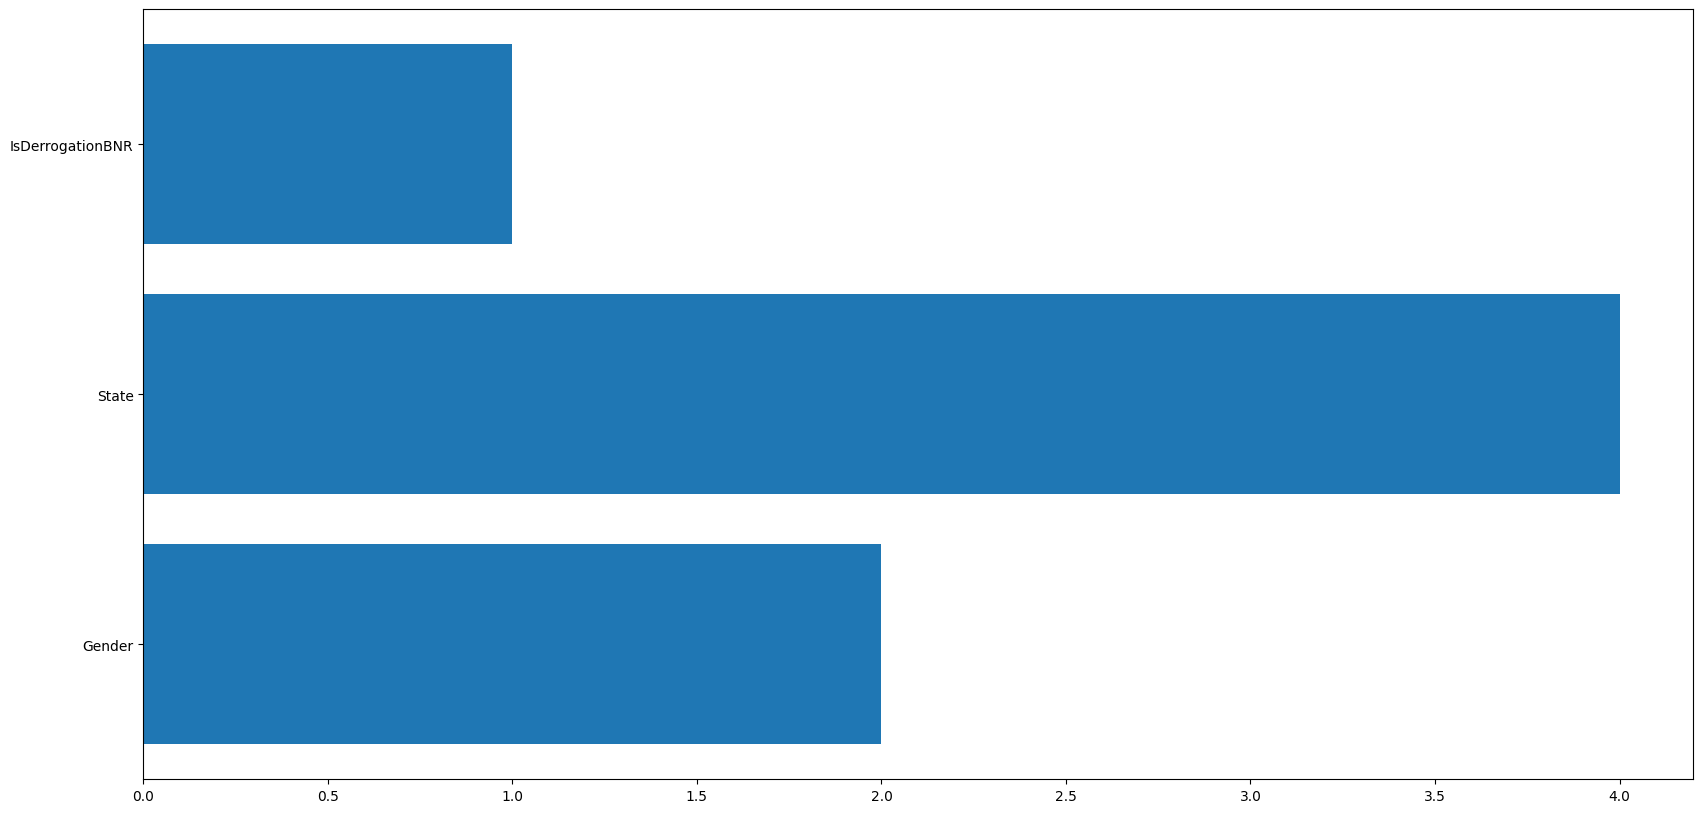

In [14]:
fig = plt.figure(figsize = (20,10))
plt.barh(ob_coll,object_values, label = 'values')

In [15]:
df['IsDerrogationBNR'].value_counts()

True    1111
Name: IsDerrogationBNR, dtype: int64

In [16]:
df['IsDerrogationBNR']=df['IsDerrogationBNR'].fillna(False)

In [17]:
df['State'].value_counts()

Inchis       6827
Activ        5429
Executare     259
Moneysend       1
Name: State, dtype: int64

In [18]:
df = df[df['State'] != 'Moneysend']

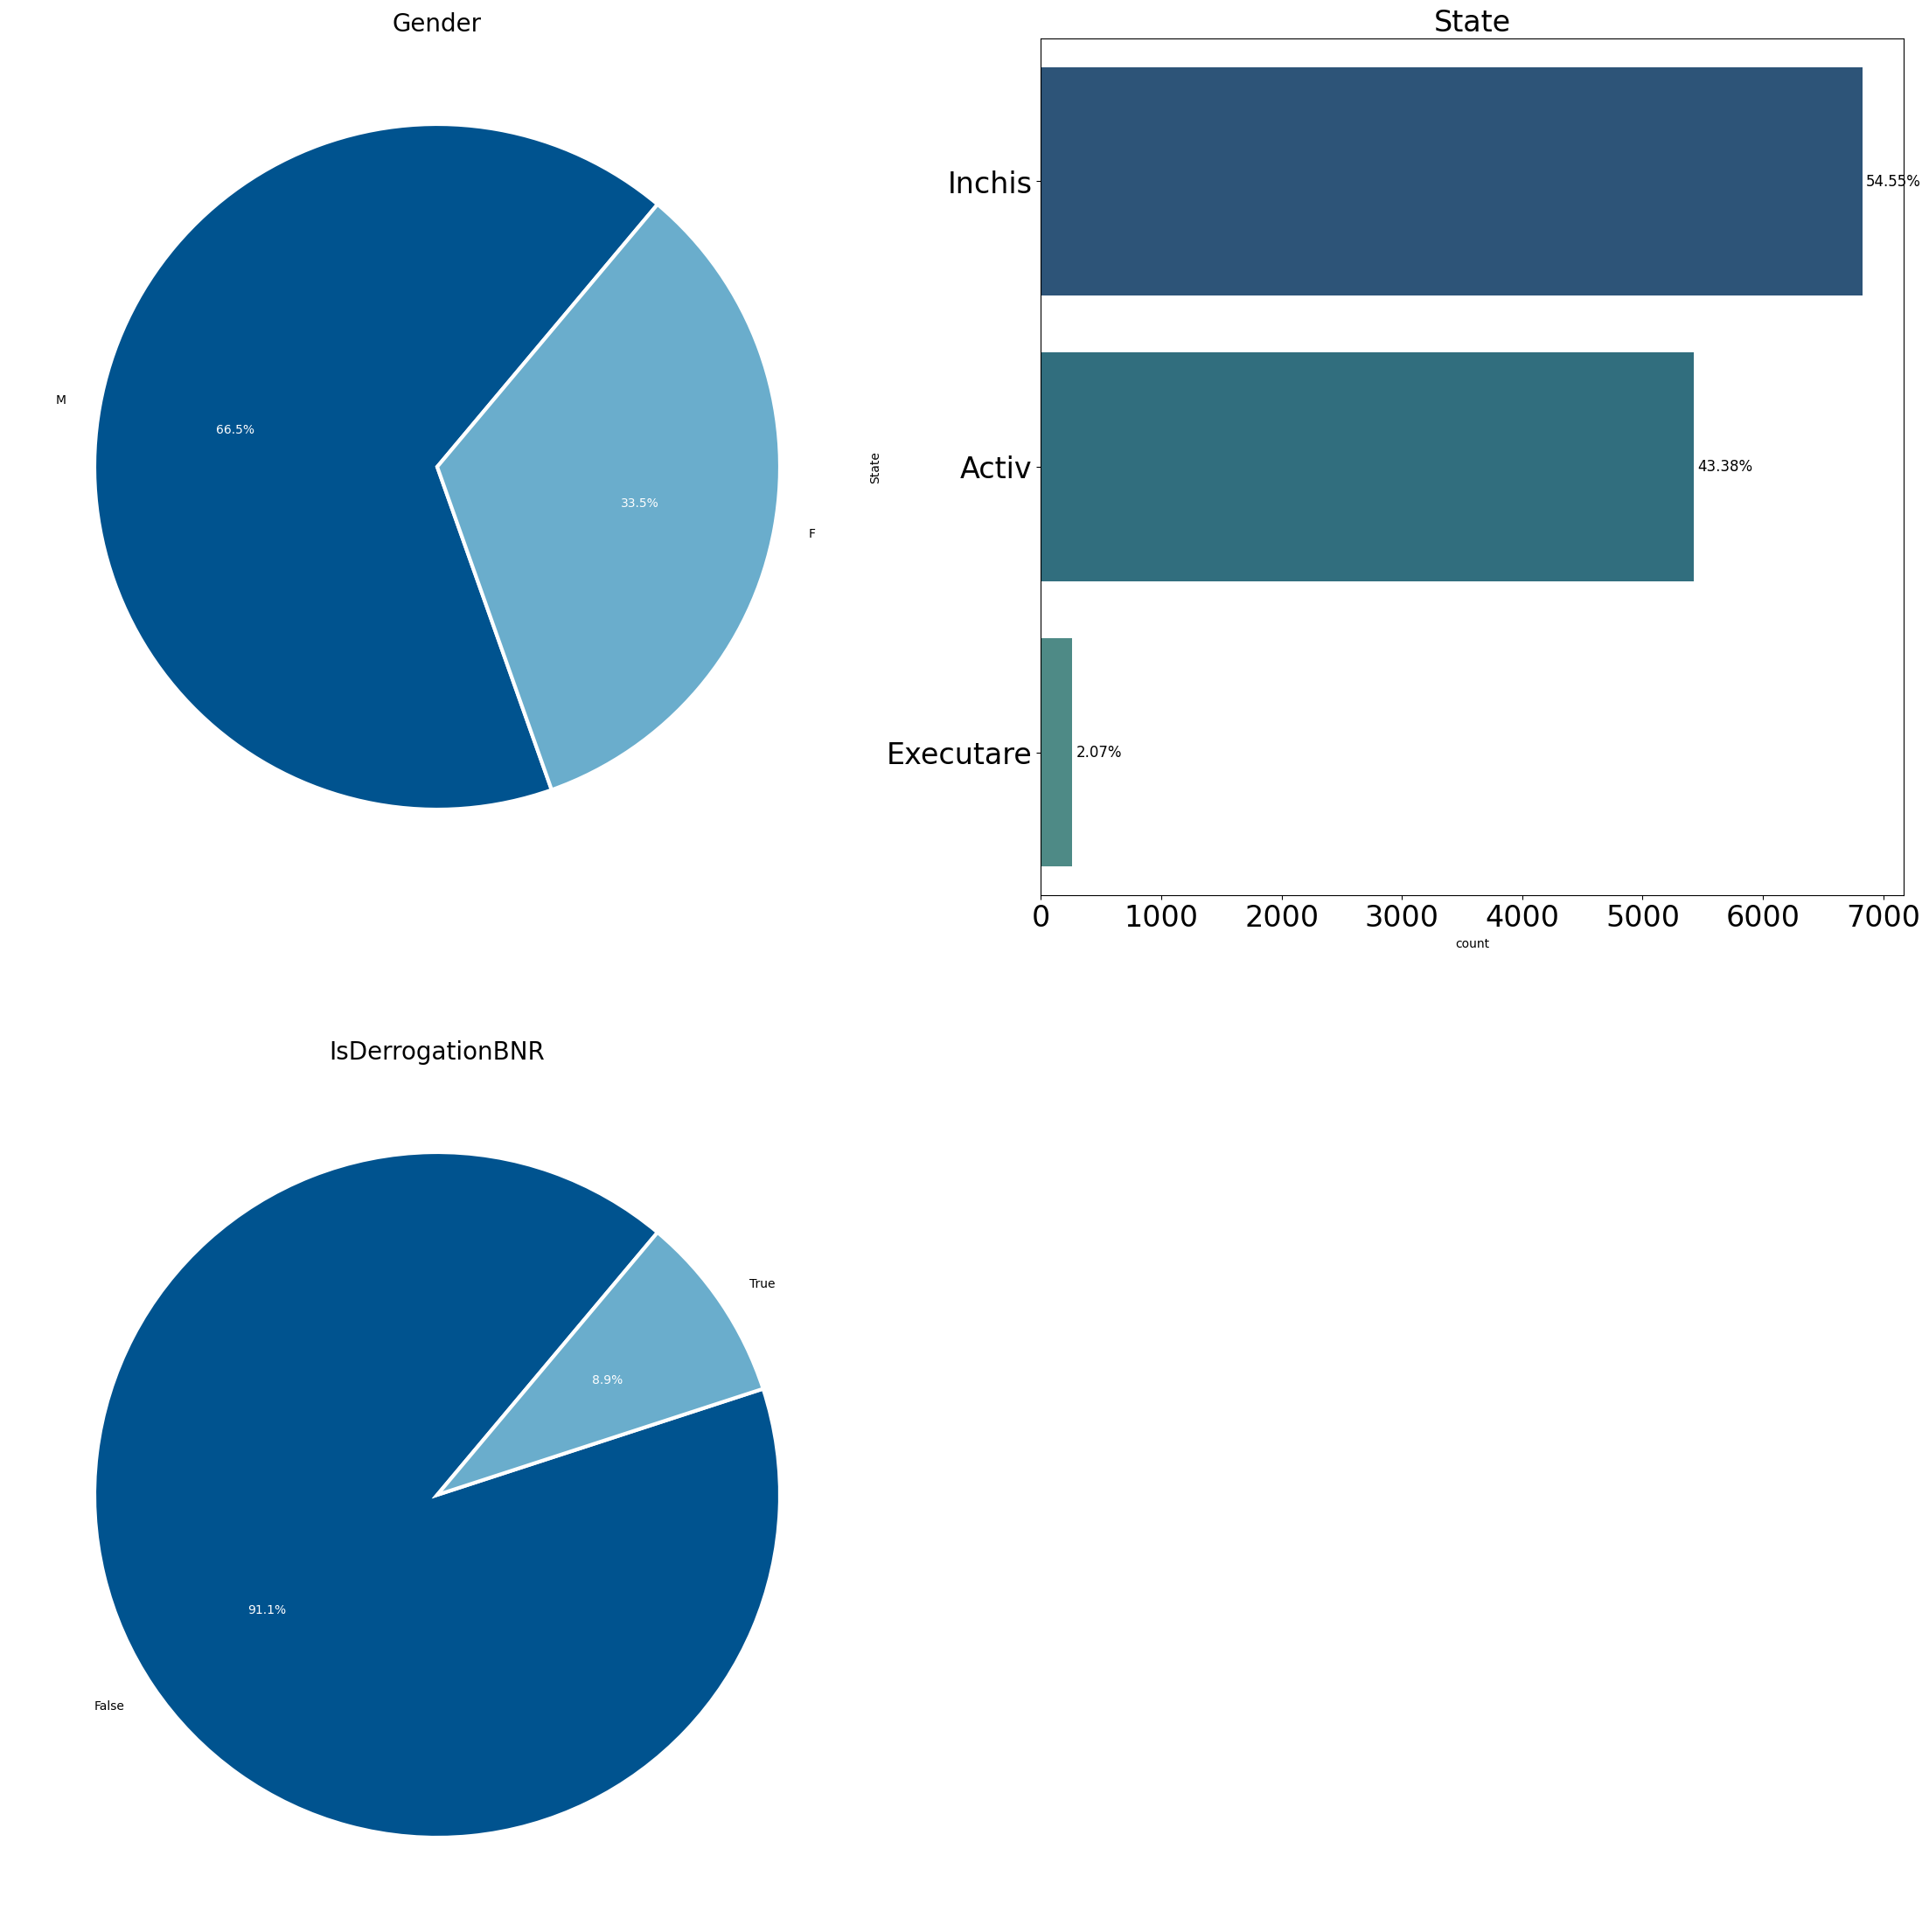

In [19]:
fig, ax = plt.subplots(figsize =(28, 28))
fig.patch.set_facecolor('white')
colors = sns.color_palette("crest_r", n_colors=4).as_hex()

for i in (enumerate(ob_coll)):
    plt.subplot(2, 2, i[0]+1)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    
    if df[i[1]].value_counts().count() > 2:
        ax = sns.countplot(y = i[1], data = df, order=df[i[1]].value_counts().index, palette=colors)
        pct = df[i[1]].value_counts(ascending=False, normalize=True).values * 100
        ax.bar_label(container=ax.containers[0], labels=list(map('{:.2f}%'.format,pct)), padding=3, size=12, color='black')
        ax.grid(False)
        plt.title(i[1], fontsize=24, color='black')
        

    else:
        _, texts, pcts = plt.pie(
            df[i[1]].value_counts(), 
            labels=df[i[1]].value_counts().index, 
            colors= ['#00538F', '#6AADCC'],
            autopct='%1.1f%%', 
            wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
            startangle=50)
        for pcts in pcts:
          pcts.set_color('white')
        plt.title(i[1], fontsize=20, color='black')
        plt.xticks(fontsize=24)
        plt.yticks(fontsize=24)


plt.show()  

<function matplotlib.pyplot.show(close=None, block=None)>

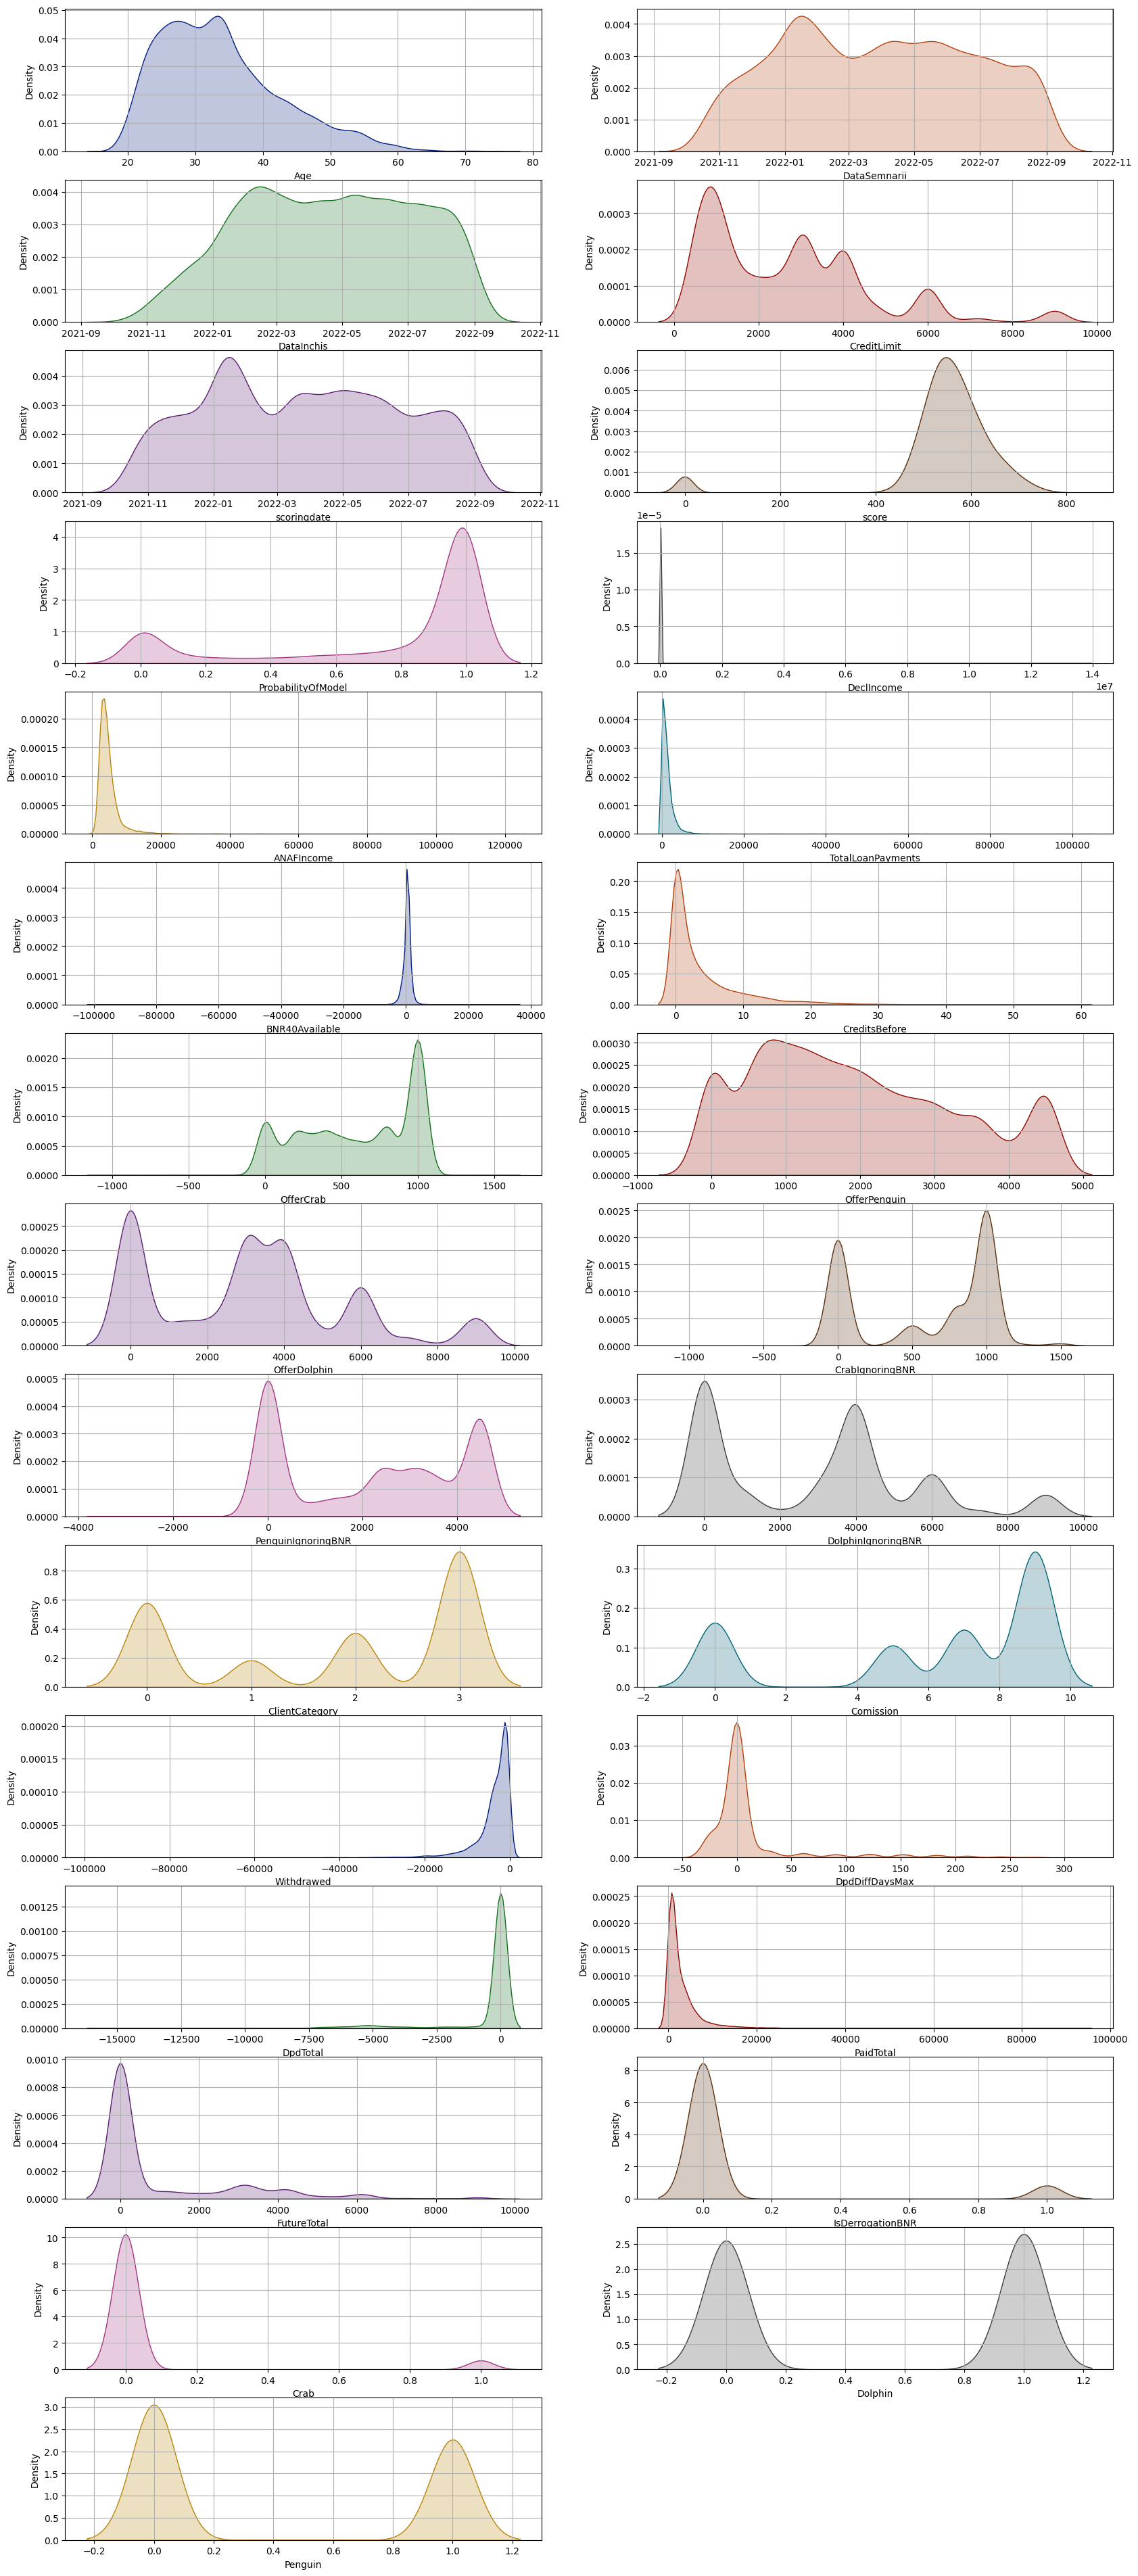

In [20]:
# Select numerical variables
numeric = df.select_dtypes(exclude=object).columns
fig, ax = plt.subplots(figsize =(20, 65))
fig.patch.set_facecolor('white')
colors = sns.color_palette("dark", n_colors=30).as_hex()

for i in (enumerate(numeric)):
    plt.subplot(20, 2, i[0]+1)
    sns.kdeplot(x = i[1], data = df, color=colors[i[0]], fill=True)
    plt.grid()
plt.show

In [21]:
df.columns

Index(['Gender', 'Age', 'DataSemnarii', 'DataInchis', 'CreditLimit', 'State',
       'scoringdate', 'score', 'ProbabilityOfModel', 'DeclIncome',
       'ANAFIncome', 'TotalLoanPayments', 'BNR40Available', 'CreditsBefore',
       'OfferCrab', 'OfferPenguin', 'OfferDolphin', 'CrabIgnoringBNR',
       'PenguinIgnoringBNR', 'DolphinIgnoringBNR', 'ClientCategory',
       'Comission', 'Withdrawed', 'DpdDiffDaysMax', 'DpdTotal', 'PaidTotal',
       'FutureTotal', 'IsDerrogationBNR', 'Crab', 'Dolphin', 'Penguin'],
      dtype='object')

#### By federal law, a late payment cannot be reported to the credit reporting bureaus until it is at least 30 days past due. An overlooked bill won't hurt your credit as long as you pay before the 30-day mark, although you may have to pay a late fee

## How many days can you be late on a payment?

### 30days 

https://www.equifax.com/personal/education/credit-cards/when-late-credit-card-payments-post/#:~:text=Generally%20speaking%2C%20the%20reporting%20date,are%2060%20days%20past%20due.

In [22]:
df.loc[(df['DpdDiffDaysMax'] > 30)& (df['IsDerrogationBNR'] ==False), ['Withdrawed', 'DpdDiffDaysMax', 'DpdTotal', 'PaidTotal',
       'FutureTotal', 'IsDerrogationBNR','State']]
# y_pinguin = df_total.loc[df_total['Produs'] == 2, 'State']
# y_delfin=df_total.loc[df_total['Produs'] == 1, 'State']

,Withdrawed,DpdDiffDaysMax,DpdTotal,PaidTotal,FutureTotal,IsDerrogationBNR,State
8,-2500.00,280,-3020.66,135.35,0.00,False,Executare
10,-2100.00,64,0.00,2487.47,0.00,False,Inchis
19,-6000.00,273,-10028.67,671.11,0.00,False,Executare
21,-3000.00,303,-5406.78,10.00,0.00,False,Executare
28,-3652.21,211,-5337.73,1083.21,0.00,False,Executare
...,...,...,...,...,...,...,...
10227,-500.00,39,-250.24,179.03,208.06,False,Activ
10253,-1200.00,38,-1065.36,0.00,499.36,False,Activ
10316,-1000.00,35,-880.27,0.00,416.14,False,Activ
10393,-2000.00,31,-1740.51,0.00,832.26,False,Activ


### Dupa ce in primul notebook  am incercat sa transform coloana 'State' in target unde clienti riscanti fiind persoanele ale caror credit era in executare, iar cel inchis fiind client bun, am constientizat ca am realizat o greseala,deoare sunt si persoane ale caror credit este inchis, dar au trecut limita de 90 de zile la achitare

### De data aceasta ca clienti riscanti, vor fi cei care au creditul in executare,sau au trecut limita maxima cu 30 de zile,(contractul sa fie minim de 60 de zile,aceasta durata se va calcula din data maxima prezenta in coloana de inchidere, minus data de semnare la credit activ

In [23]:
max_datetime = df['DataInchis'].max()
df.loc[df['DataInchis'].isnull() , 'durata_contract']=(max_datetime - df['DataSemnarii']).dt.days
df.loc[df['DataInchis'].notnull() , 'durata_contract']=(df['DataInchis'] - df['DataSemnarii']).dt.days

### Am calculat durata contractului
#### Nu mai avem nevoie de datetime-uri


## Selectam clientii riscanti

In [24]:
df.loc[(df['IsDerrogationBNR'] ==False)&((df['durata_contract'] > 60) & (df['DpdDiffDaysMax'] >= 50)), 'target']=1    

In [25]:
df.loc[df['DpdDiffDaysMax'] < 30,'target']=0 # clientiti buni

In [26]:
df.loc[df['target'].isnull(),['Withdrawed', 'DpdDiffDaysMax', 'DpdTotal', 'PaidTotal',
       'FutureTotal', 'IsDerrogationBNR','durata_contract','State']]

,Withdrawed,DpdDiffDaysMax,DpdTotal,PaidTotal,FutureTotal,IsDerrogationBNR,durata_contract,State
171,-6939.03,37,0.00,8676.39,0.0,False,226.0,Inchis
174,-9254.22,30,-3560.00,7896.22,0.0,False,311.0,Activ
305,-5309.74,30,-3570.00,3889.94,0.0,False,312.0,Activ
337,-6000.00,30,-3160.71,6574.66,0.0,False,311.0,Activ
383,-1200.00,34,0.00,1403.83,0.0,False,122.0,Inchis
...,...,...,...,...,...,...,...,...
11044,-3300.00,30,-3932.77,189.23,0.0,False,39.0,Activ
11157,-5200.00,30,-4013.00,2000.00,0.0,False,39.0,Activ
11210,-3200.00,30,-4003.00,10.00,0.0,False,37.0,Activ
11263,-2200.00,30,-2836.00,0.00,0.0,False,35.0,Activ


### Voi face drop la aceste randuri,deoarece nu reprezinta o informatie care se atribuie concret la client bun sau rau,deoarece sunt unele persoane car au 39 de zile contractul,dar dar intarziere 30 de zile,inseamna ca trebuie rambunsat dupa 9 zile,dar cel mai mic credit,crab,este de 30 de zile, de asta am cautat anterioe,daca contractul e mai lung de 60 de zile,adica 30 de zile pana la data de plata +30 de zile intarziere

#### Facem drop la coloanele datetime,deoarece am extras deja informatia necesara din ele

In [27]:
df=df.drop(['DataInchis','DataSemnarii','scoringdate'],axis=1)

In [28]:
df.isnull().sum()

Gender                  0
Age                     0
CreditLimit             0
State                   0
score                   0
ProbabilityOfModel      0
DeclIncome              0
ANAFIncome              0
TotalLoanPayments       0
BNR40Available          0
CreditsBefore           0
OfferCrab               0
OfferPenguin            0
OfferDolphin            0
CrabIgnoringBNR         0
PenguinIgnoringBNR      0
DolphinIgnoringBNR      0
ClientCategory          0
Comission               0
Withdrawed              0
DpdDiffDaysMax          0
DpdTotal                0
PaidTotal               0
FutureTotal             0
IsDerrogationBNR        0
Crab                    0
Dolphin                 0
Penguin                 0
durata_contract         0
target                405
dtype: int64

In [29]:
df=df.dropna()

In [30]:
df['IsDerrogationBNR'].value_counts()

False    11118
True       992
Name: IsDerrogationBNR, dtype: int64

### Facem drop la aceasta coloana,deoarece la aplicarea pentru credit noi nu stim daca va urma derogare,iar acest lucru poate inrautati antrenarea

In [31]:
df=df.drop('IsDerrogationBNR',axis=1)

### Encodam datele categoriale

In [32]:
object_values=[]
ob_coll=df.select_dtypes(object).columns
for column in ob_coll:
     object_values.append(np.count_nonzero(df[column].value_counts()))

In [33]:
lbl_enc=LabelEncoder()
df[ob_coll]=df[ob_coll].astype(str).apply(lbl_enc.fit_transform)

<Axes: >

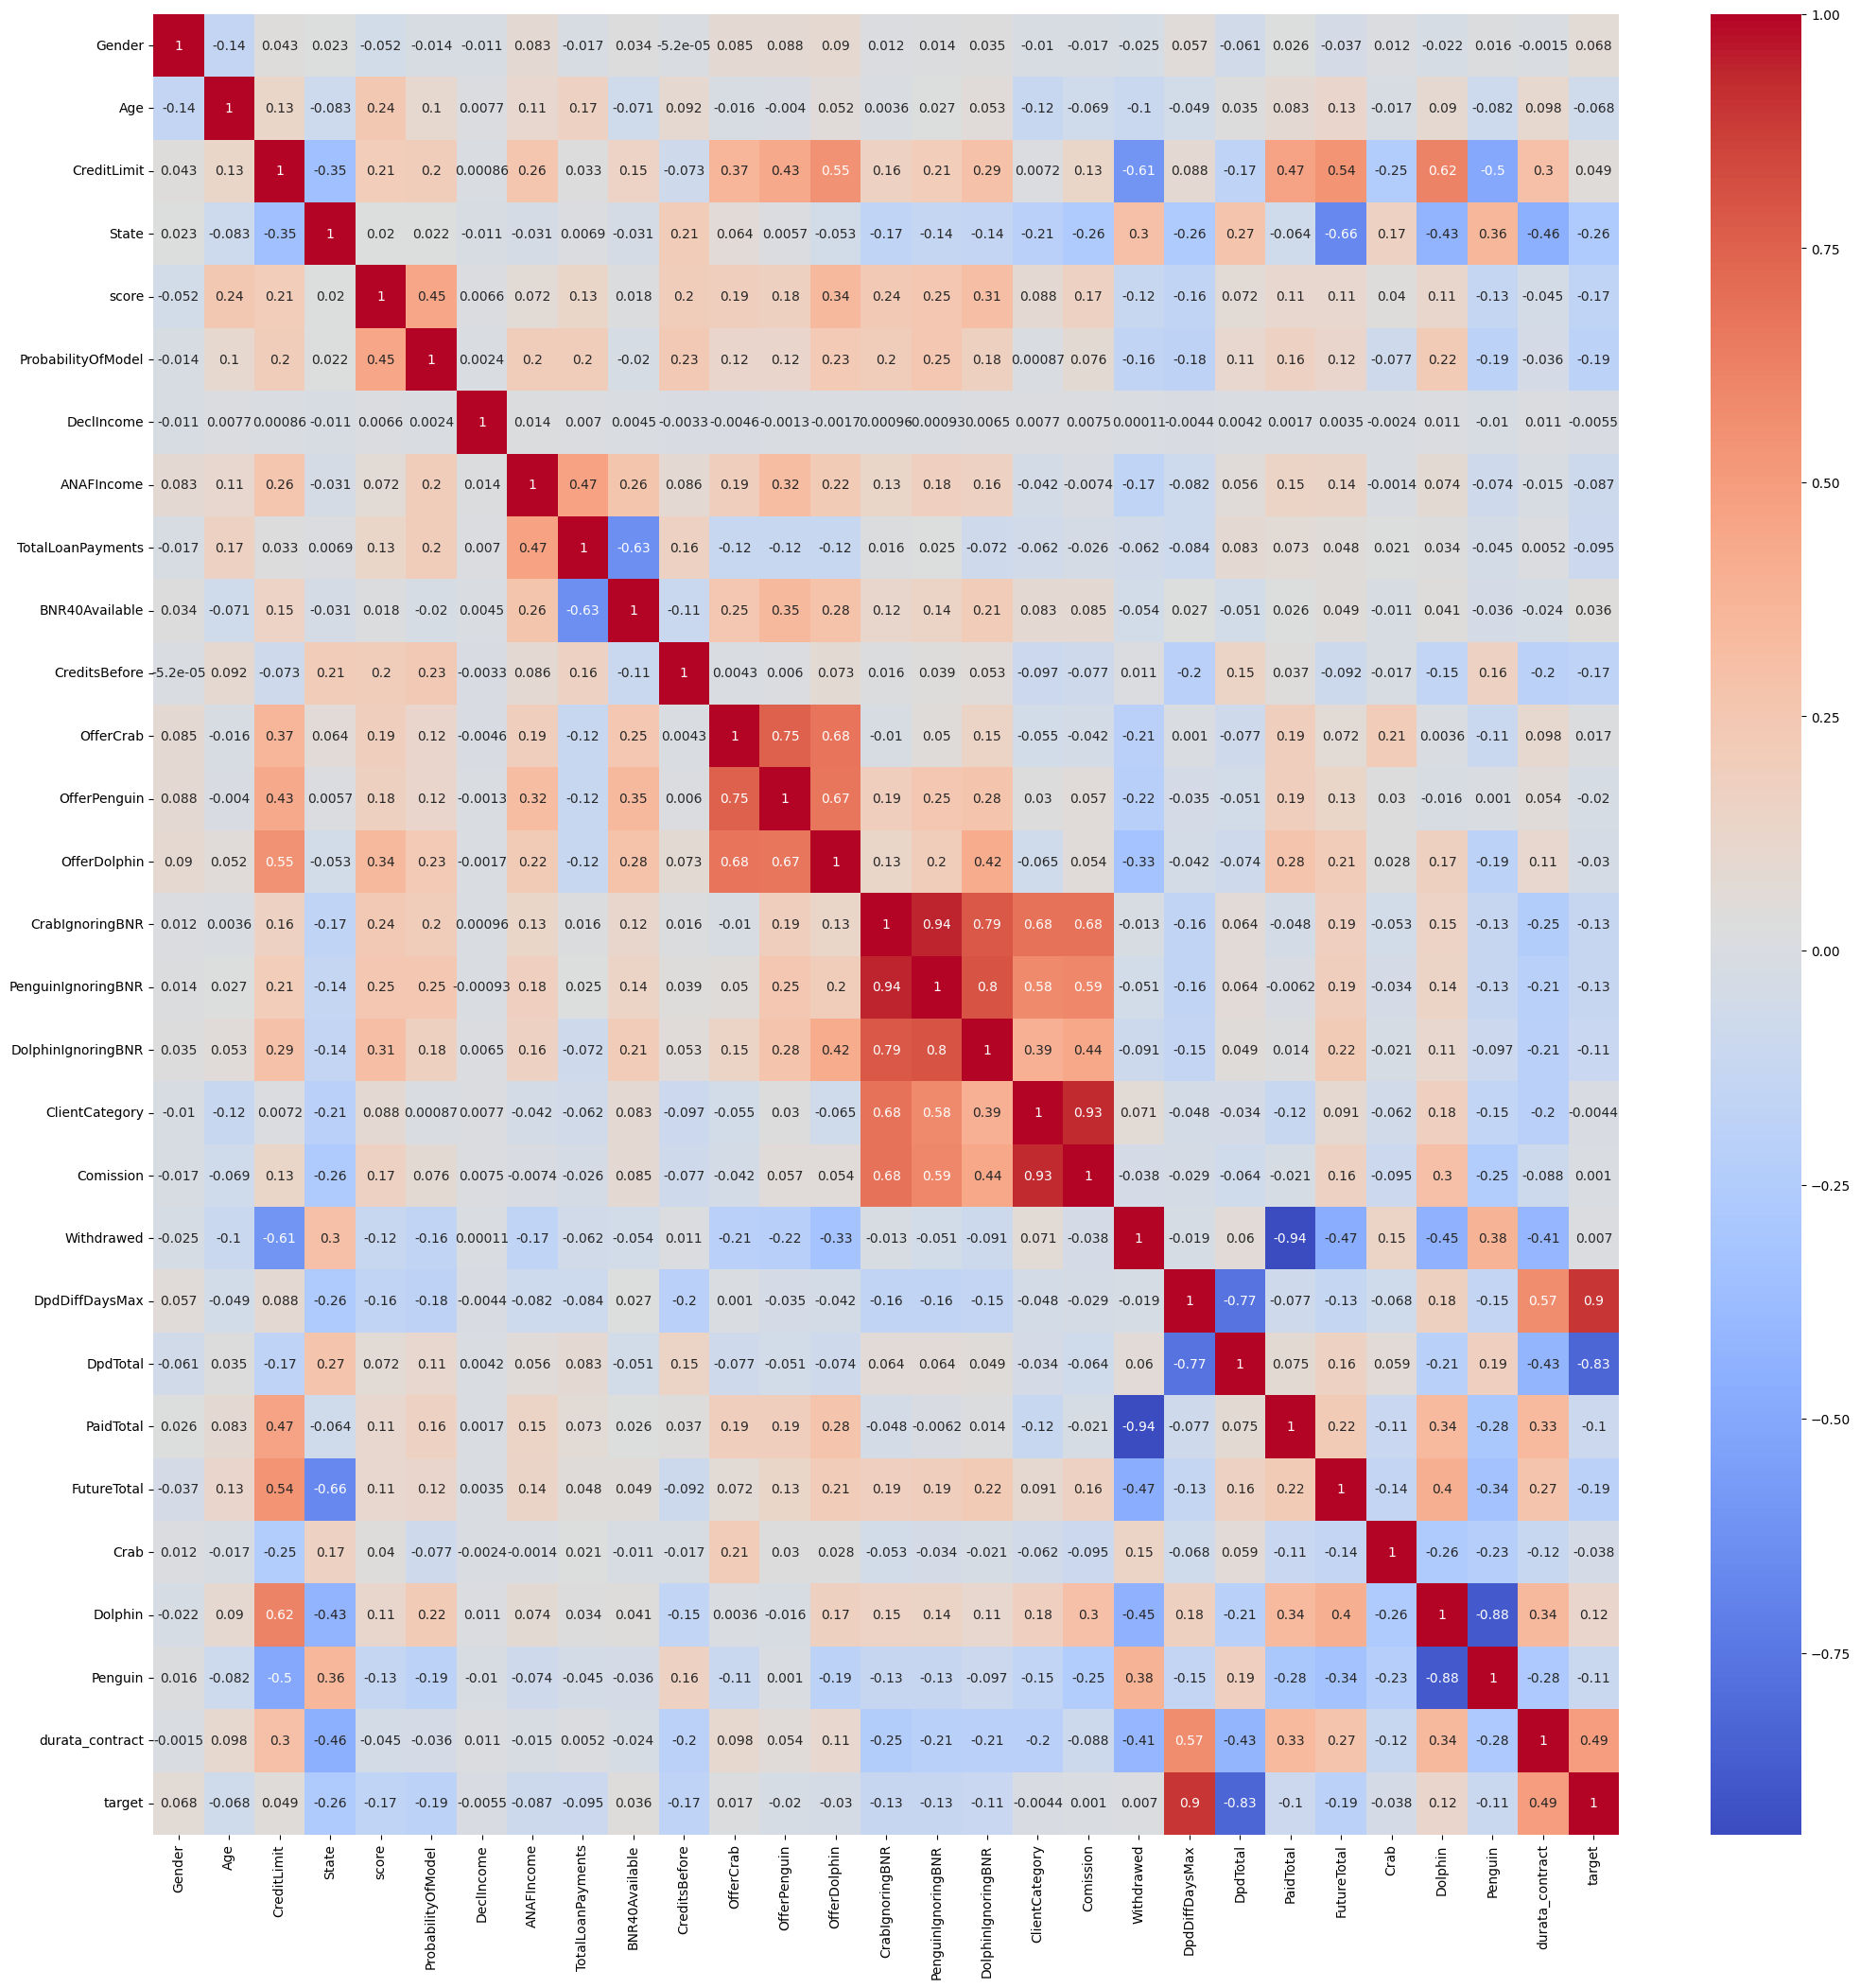

In [34]:
plt.figure(figsize=(25,25))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm')

### Deoarece clientii sunt clasificati in baza intarzierii,vom face drop la coloanele de DPD

In [35]:
df=df.drop(['DpdDiffDaysMax','DpdTotal'],axis=1)

In [36]:
work_df=df

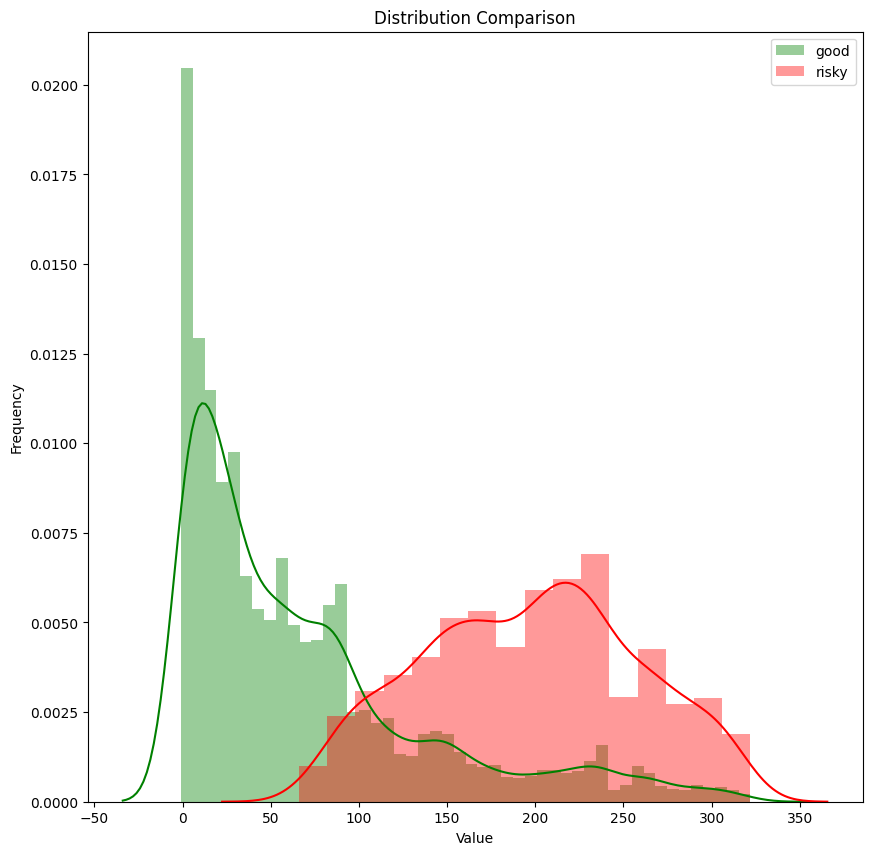

In [37]:
plt.figure(figsize=(10,10))
#sns.kdeplot(df['durata_contract'], shade=True, label='Distribution durata and target')
#sns.kdeplot(df['target'], shade=True, label='Distribution durata and target')
sns.distplot(df['durata_contract'][df['target']==0],color='g', label = 'good')
sns.distplot(df['durata_contract'][df['target']==1],color='r', label = 'risky')
#sns.kdeplot(df['target'], shade=True, label='Distribution durata and target')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution Comparison')
plt.legend()

plt.show()

### Observam ca cu cat durata contractului e mai mare cu atat si numarul de clienti riscanti creste

In [38]:
df.columns

Index(['Gender', 'Age', 'CreditLimit', 'State', 'score', 'ProbabilityOfModel',
       'DeclIncome', 'ANAFIncome', 'TotalLoanPayments', 'BNR40Available',
       'CreditsBefore', 'OfferCrab', 'OfferPenguin', 'OfferDolphin',
       'CrabIgnoringBNR', 'PenguinIgnoringBNR', 'DolphinIgnoringBNR',
       'ClientCategory', 'Comission', 'Withdrawed', 'PaidTotal', 'FutureTotal',
       'Crab', 'Dolphin', 'Penguin', 'durata_contract', 'target'],
      dtype='object')

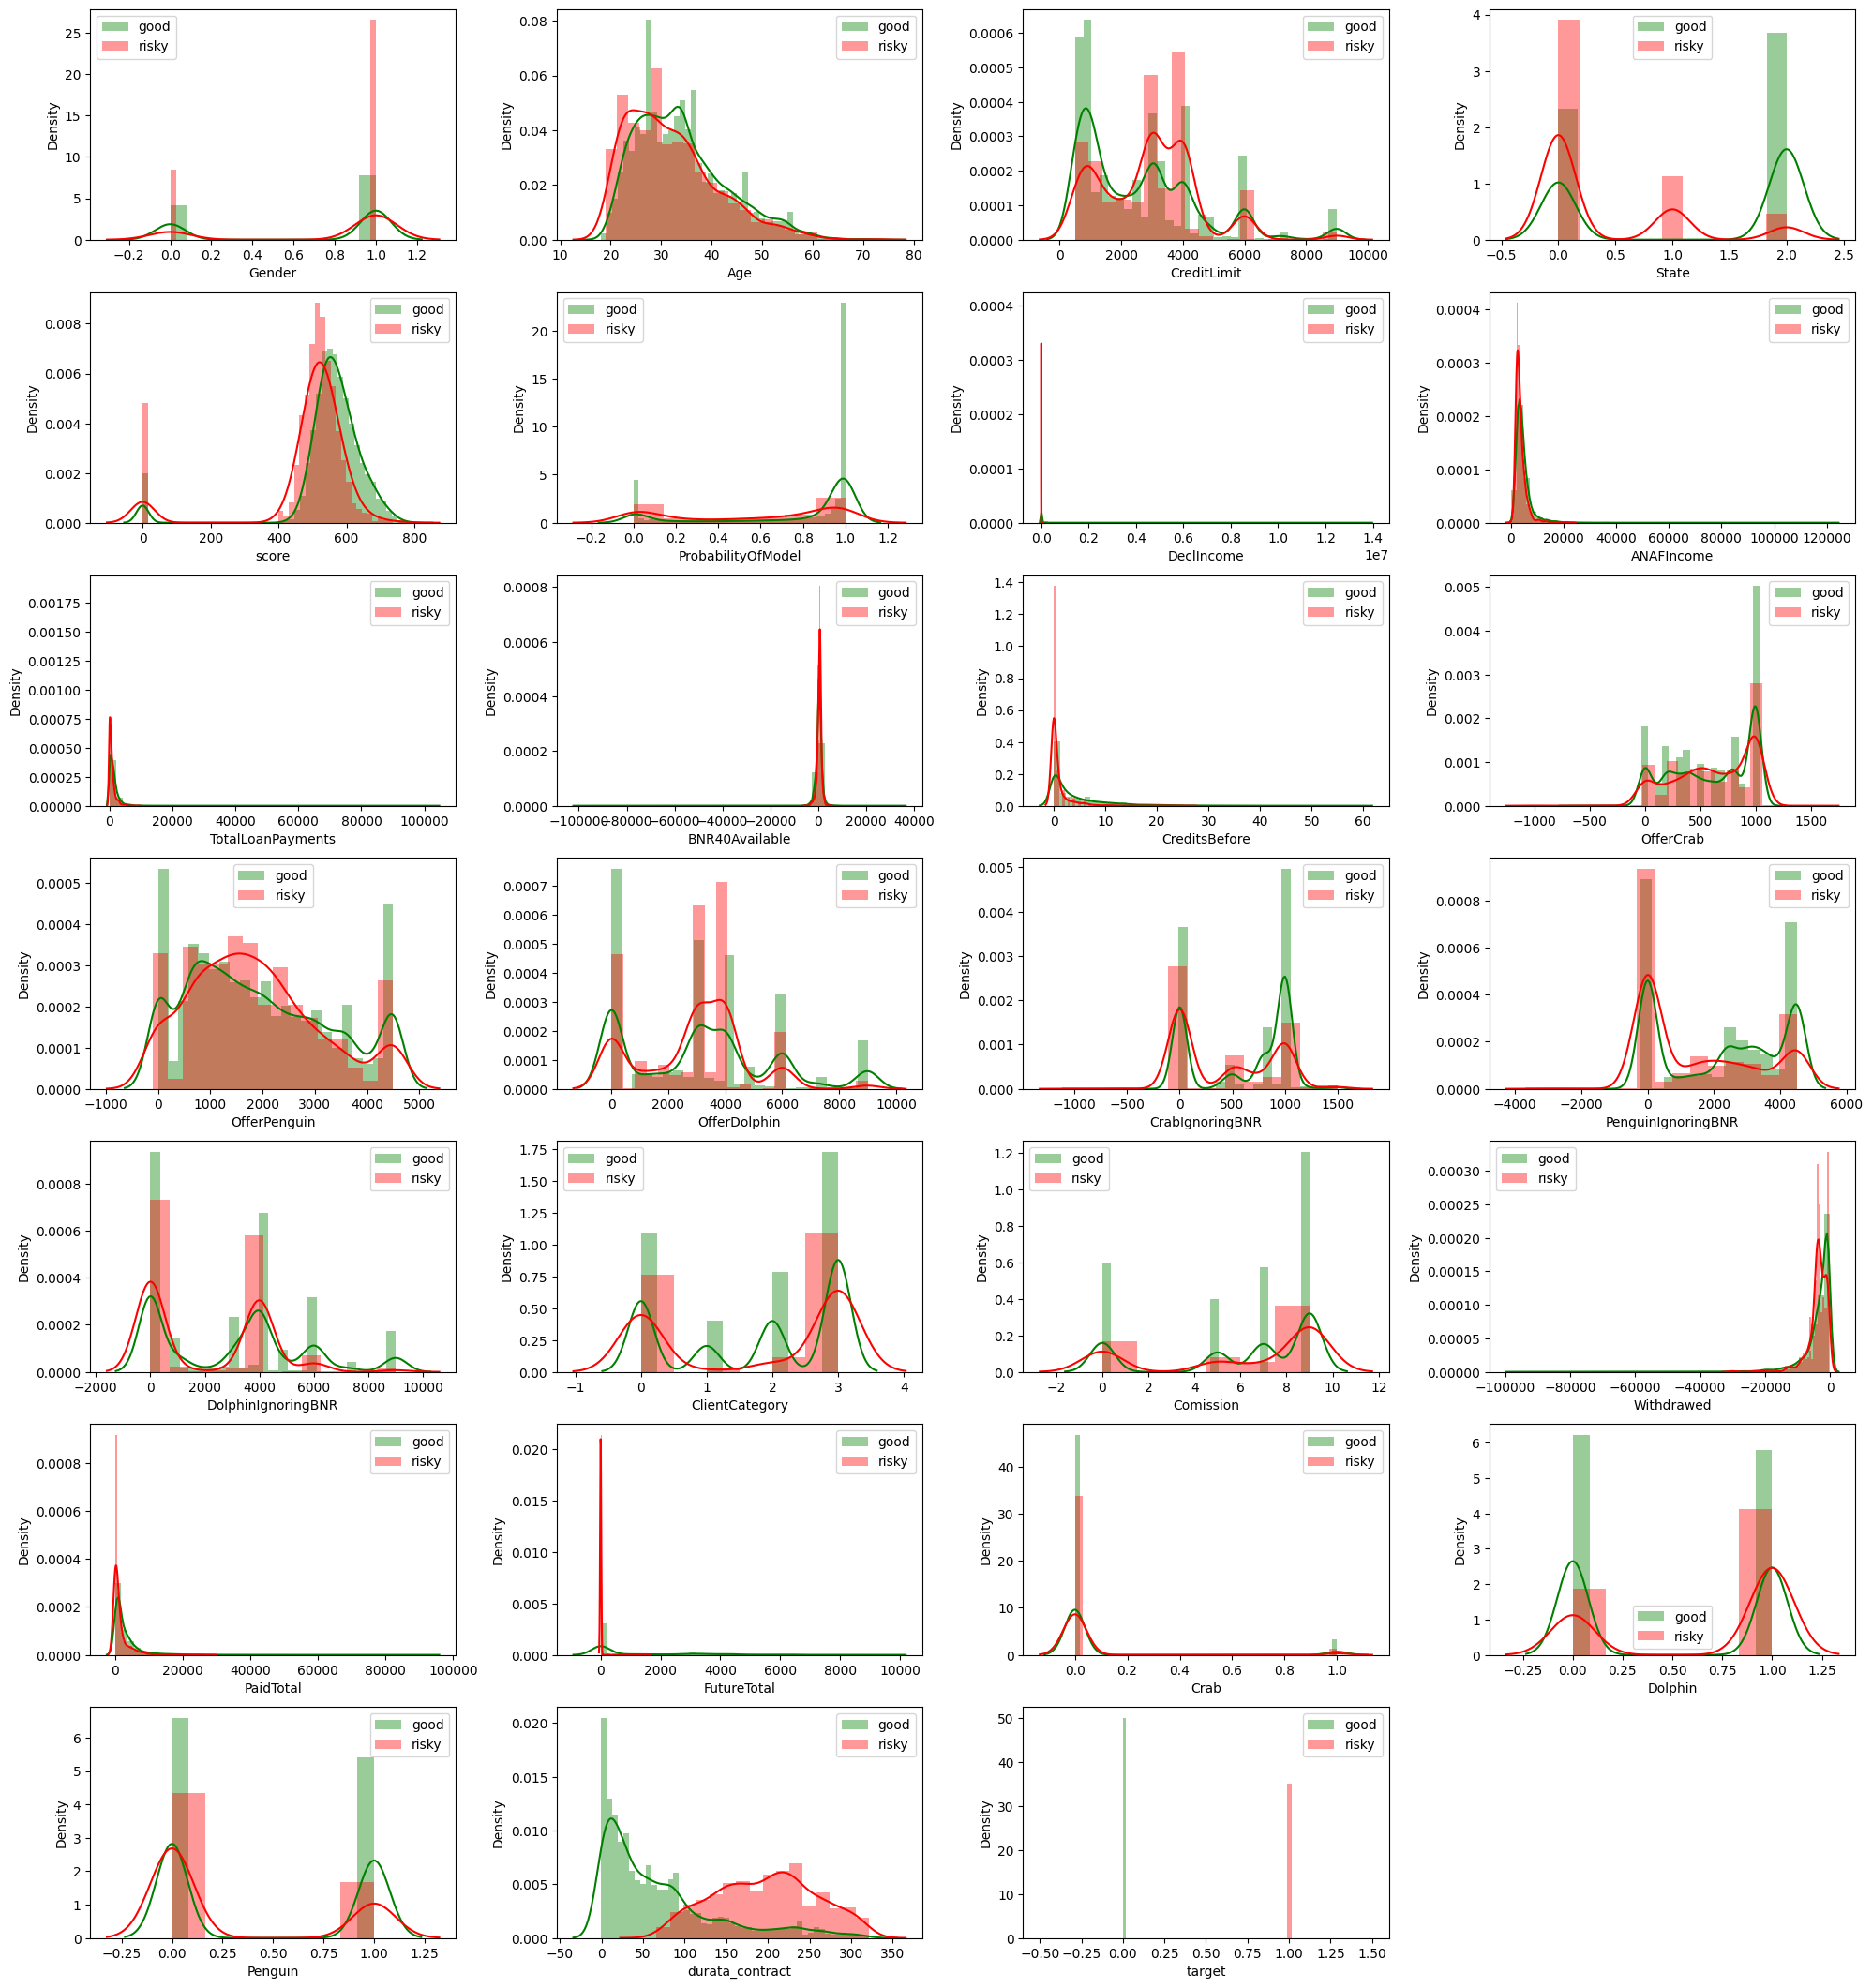

In [39]:
fig = plt.figure(figsize = (20, 25))
j = 0

for column in df:
    plt.subplot(8, 4, j+1)
    j += 1
    sns.distplot(df[column][df['target']==0],color='g', label = 'good')
    sns.distplot(df[column][df['target']==1],color='r', label = 'risky')
    plt.legend(loc='best')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

### Vom crea 3 modele, pentru fiecare produs cate unul,mai intai cream pentru produsul 
# 🦀 Crab
### Incepem sa pregatim datele

In [40]:
df_crab=df.loc[df['Crab']==1]
df_crab=df_crab.drop(['Dolphin','Penguin','Crab'],axis=1)
df_delfin=df.loc[df['Dolphin']==1]
df_delfin=df_delfin.drop(['Dolphin','Penguin','Crab'],axis=1)
df_pinguin=df.loc[df['Penguin']==1]
df_pinguin=df_pinguin.drop(['Dolphin','Penguin','Crab'],axis=1)

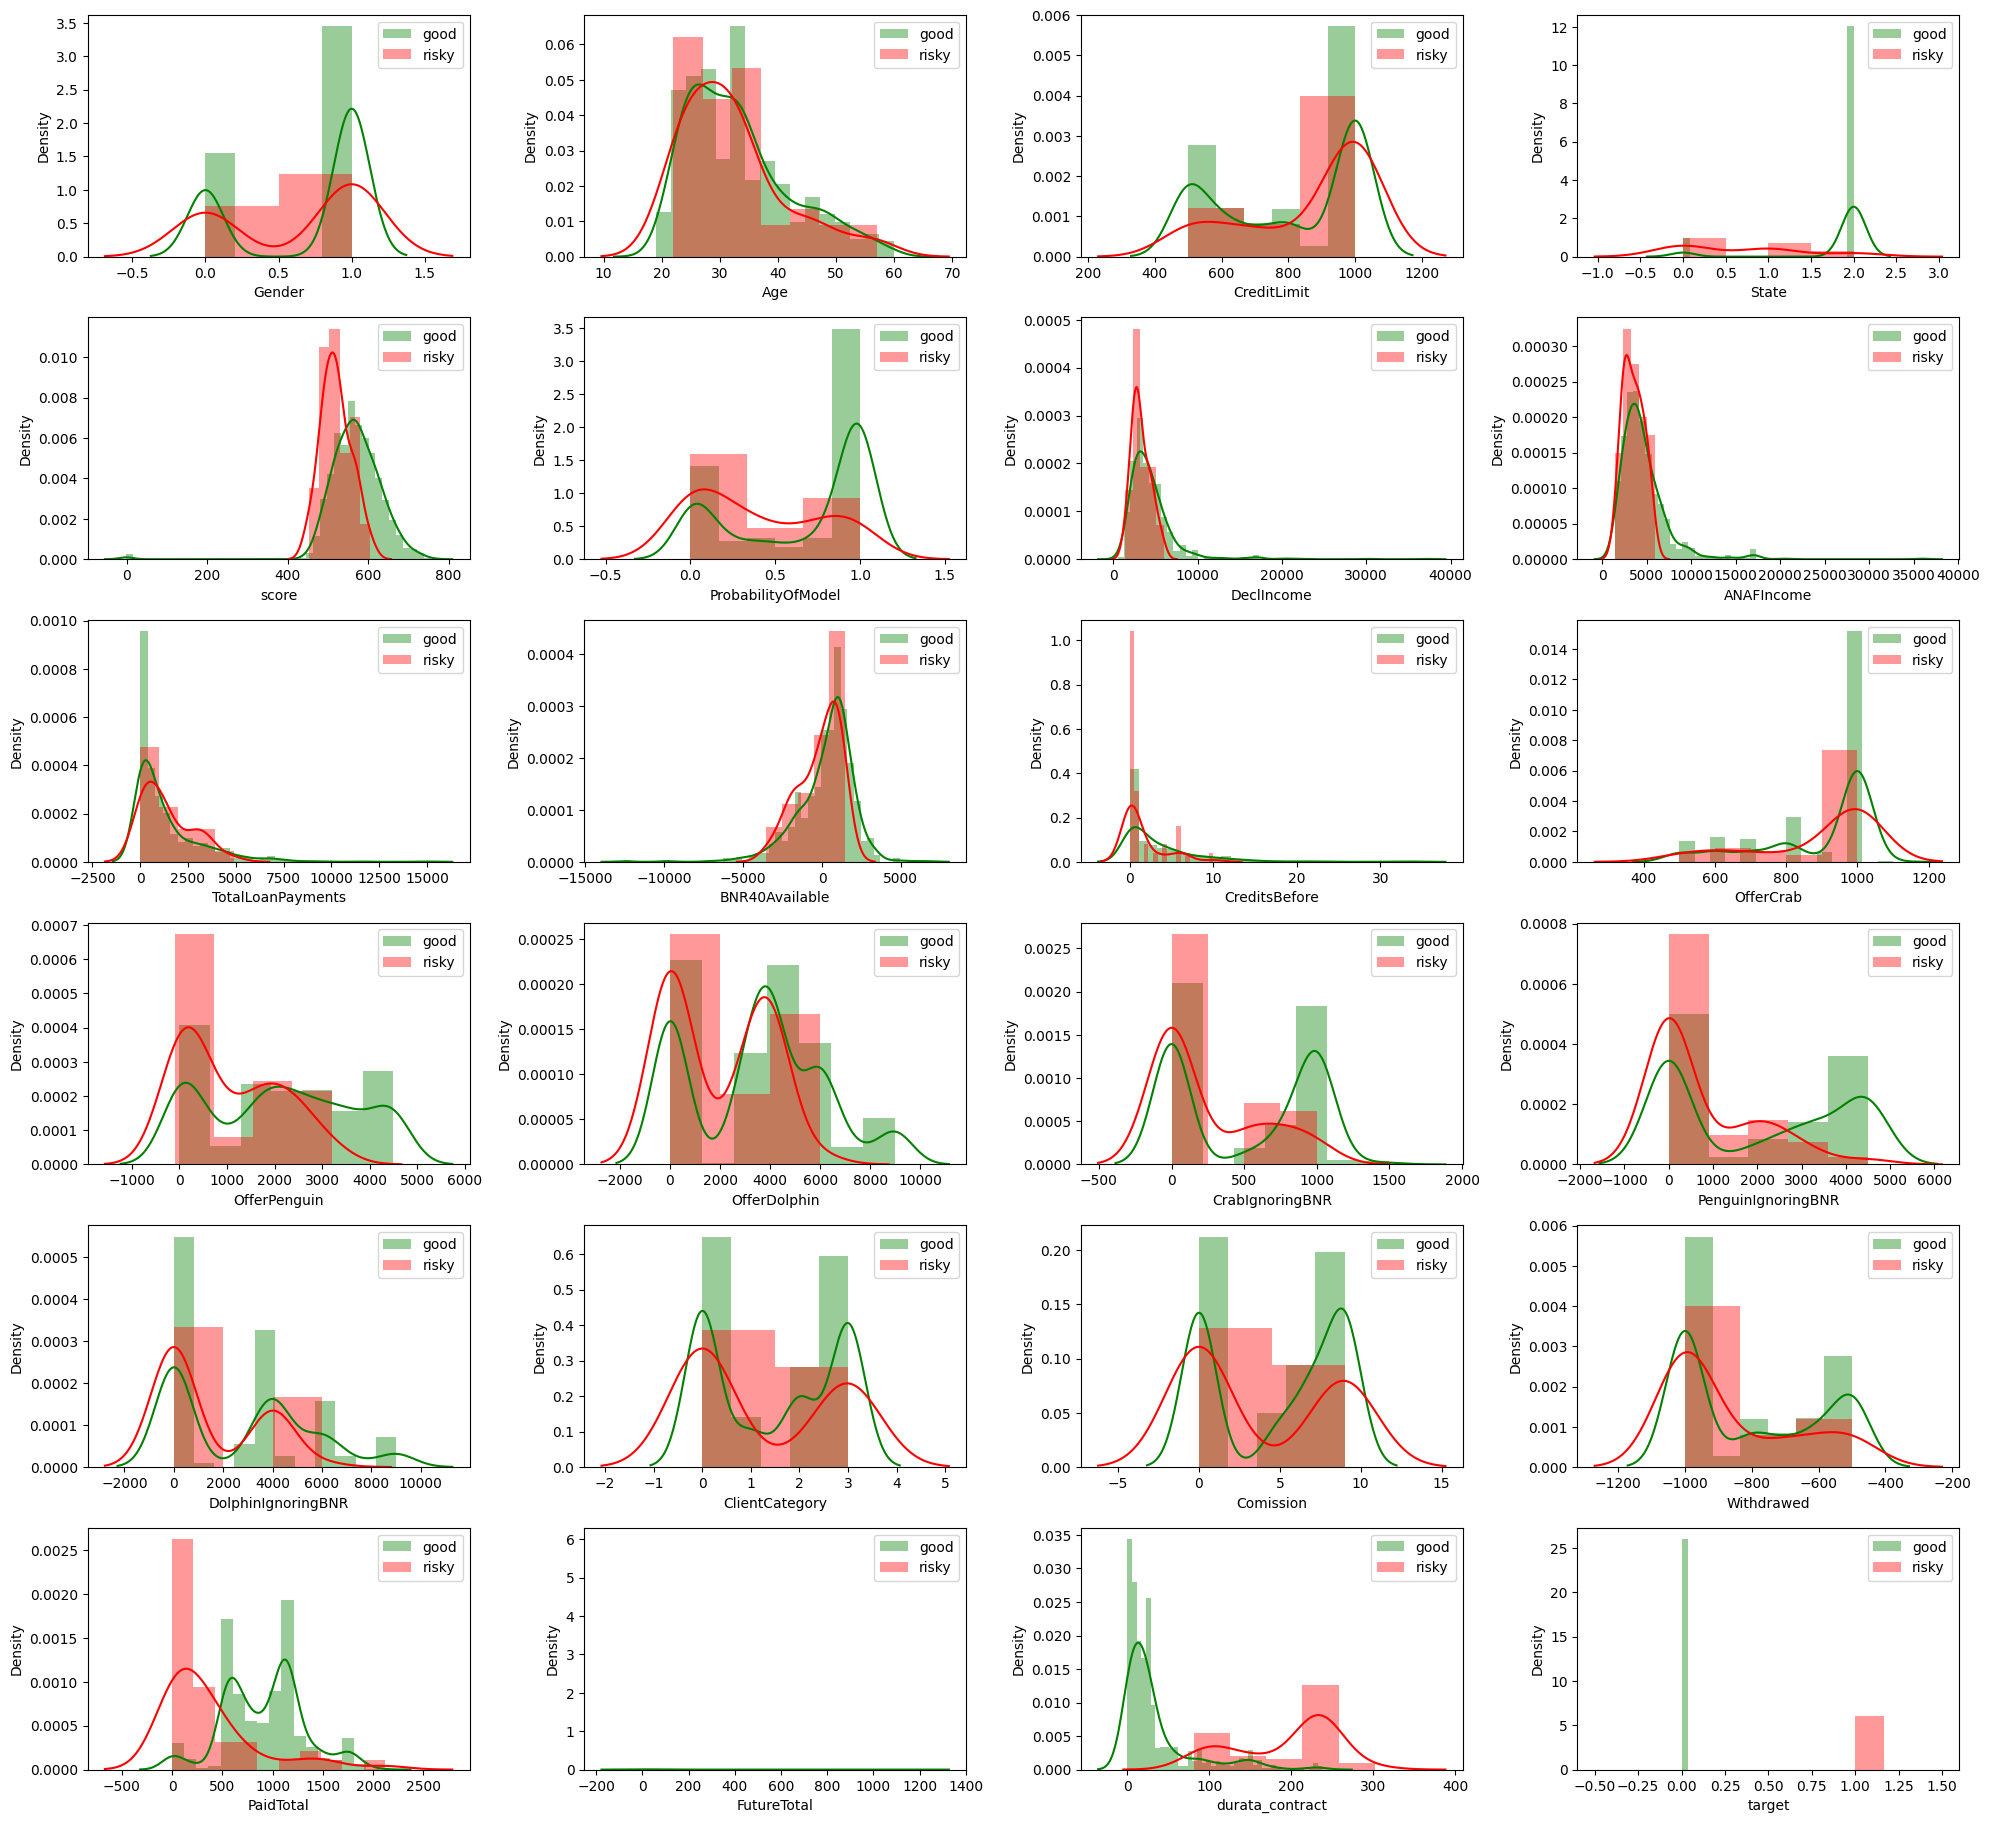

In [41]:
fig = plt.figure(figsize = (20, 25))
j = 0

for column in df_crab:
    plt.subplot(8, 4, j+1)
    j += 1
    sns.distplot(df_crab[column][df_crab['target']==0],color='g', label = 'good')
    sns.distplot(df_crab[column][df_crab['target']==1],color='r', label = 'risky')
    plt.legend(loc='best')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [42]:
y_crab=df_crab['target']
X_crab=df_crab.drop(['State','ProbabilityOfModel', 'OfferPenguin',
       'OfferDolphin','PenguinIgnoringBNR','DolphinIgnoringBNR', 'ClientCategory', 'Comission', 'Withdrawed',
       'PaidTotal', 'FutureTotal', 'durata_contract', 'target','DeclIncome'],axis=1)

In [43]:
X_crab.columns

Index(['Gender', 'Age', 'CreditLimit', 'score', 'ANAFIncome',
       'TotalLoanPayments', 'BNR40Available', 'CreditsBefore', 'OfferCrab',
       'CrabIgnoringBNR'],
      dtype='object')

In [44]:

X_train,X_test,y_train,y_test=train_test_split(X_crab,y_crab,test_size=0.2,random_state=42)


              precision    recall  f1-score   support

         0.0       0.97      0.68      0.80       142
         1.0       0.15      0.73      0.25        11

    accuracy                           0.68       153
   macro avg       0.56      0.70      0.52       153
weighted avg       0.91      0.68      0.76       153



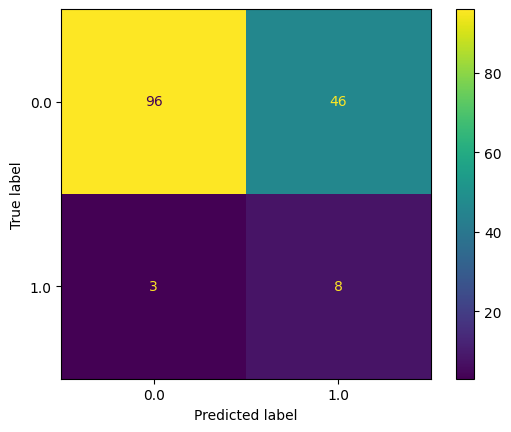

In [45]:

lr_model = LogisticRegression(random_state=42,class_weight='balanced')
lr_model.fit(X_train,y_train)
y_pred = lr_model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
print("\n"+ classification_report(y_test, y_pred))

In [46]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range =(0, 1))
X_rescaled = min_max_scaler.fit_transform(X_crab)
print ("\nAfter min max Scaling : \n", X_rescaled)


After min max Scaling : 
 [[1.         0.34146341 0.8        ... 0.08823529 0.83333333 0.        ]
 [0.         0.3902439  0.2        ... 0.         0.83333333 0.        ]
 [0.         0.34146341 0.8        ... 0.         0.66666667 0.        ]
 ...
 [1.         0.70731707 0.6        ... 0.14705882 0.5        0.8       ]
 [1.         0.04878049 0.2        ... 0.05882353 0.5        0.53333333]
 [1.         0.26829268 0.2        ... 0.14705882 0.5        0.53333333]]


In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)
pca.fit(X_rescaled)
X_pca = pca.transform(X_rescaled)

In [48]:
X_pca=pd.DataFrame(X_pca)

In [49]:
X_train,X_test,y_train,y_test=train_test_split(X_pca,y_crab,test_size=0.3,random_state=42)


              precision    recall  f1-score   support

         0.0       0.98      0.59      0.74       213
         1.0       0.14      0.82      0.24        17

    accuracy                           0.61       230
   macro avg       0.56      0.71      0.49       230
weighted avg       0.91      0.61      0.70       230



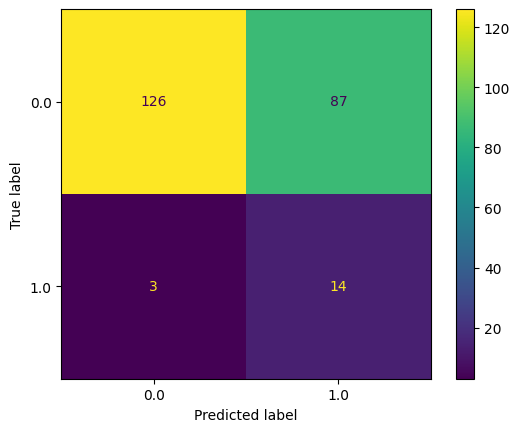

In [50]:
lr_model.fit(X_train, y_train)
y_pred_lr_is = lr_model.predict(X_test)
y_pred_lr_is=y_pred_lr_is.round(decimals=0)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_lr_is)
print("\n"+ classification_report(y_test,y_pred_lr_is))

### Aproape nesemnificativ,dar un pic mai bine

In [51]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_pca, y_crab)

In [52]:
X_train,X_test,y_train,y_test=train_test_split(X_resampled,y_resampled,test_size=0.2,random_state=42)

### Am avut overfitting mare,si am setat minim data in leaf

[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70

              precision    recall  f1-score   support

         0.0       0.96      0.83      0.89       140
         1.0       0.86      0.97      0.91       148

    accuracy                           0.90       288
   macro avg       0.91      0.90      0.90       288
weighted avg       0.91      0.90      0.90       288



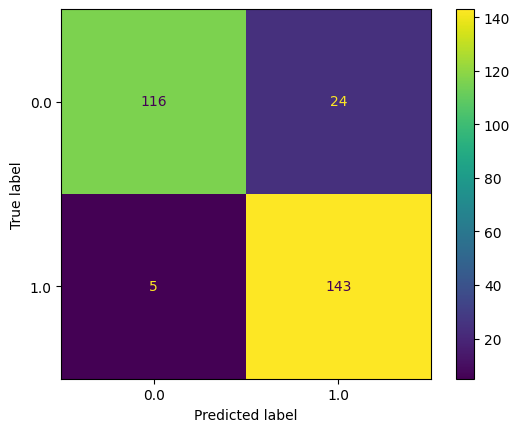

In [53]:
lgb_classifier_crab = lgb.LGBMClassifier(min_data_in_leaf=70)
#model = lgb.train(params, train_data, valid_sets=[val_data])
lgb_classifier_crab.fit(X_train,y_train)
y_pred = lgb_classifier_crab.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
print("\n"+ classification_report(y_test, y_pred))

# Crabul Gata

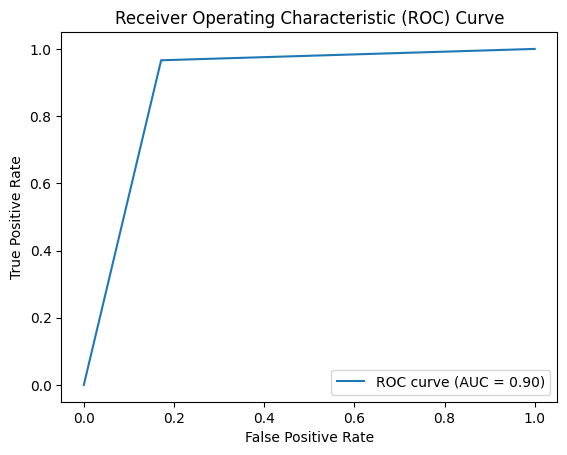

In [54]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [55]:
from sklearn.model_selection import cross_validate
def cross_validation(model, _X, _y, _cv=5):
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

In [56]:
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        # Set size of plot
        plt.figure(figsize=(12,6))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.title(plot_title, fontsize=30)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

In [58]:
lgb_result = cross_validation(lgb_classifier_crab_crab, X_resampled, y_resampled, 5)
model_name = "LGB"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            lgb_result["Training Accuracy scores"],
            lgb_result["Validation Accuracy scores"])

NameError: name 'lgb_classifier_crab_crab' is not defined

# Salvarea modelului

In [ ]:
with open('model_crab.pkl', 'wb') as file:
    pickle.dump(lgb_classifier_crab, file)

In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.decomposition import PCA
# from imblearn.pipeline import Pipeline as IMBPipeline
# from imblearn.over_sampling import SMOTE
# import lightgbm as lgb

# # Define the pipeline steps
# steps = [
#     ('scaling', MinMaxScaler(feature_range=(0, 1))),
#     ('pca', PCA(n_components=0.95)),
#     ('smote', SMOTE(sampling_strategy=0.5)),  # Adjust the sampling strategy as desired
#     ('model', lgb.LGBMClassifier())
# ]

# # Create the pipeline
# pipeline = IMBPipeline(steps)

# # Fit the pipeline to the data
# pipeline.fit(X_crab, y_crab)

# # Predict using the pipeline
# y_pred = pipeline.predict(X_test)
# ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
# print("\n"+ classification_report(y_test, y_pred))

## Tranformarea datelor de intrare

In [ ]:
row=[1,32,1900,589,4980,1283,709,6,600,0]
row = np.array(row).reshape(1, -1)
row=min_max_scaler.fit_transform(row)
row=pca.transform(row)
lgb_classifier.predict(row)

# Delfin

In [ ]:
fig = plt.figure(figsize = (20, 25))
j = 0

for column in df_delfin:
    plt.subplot(8, 4, j+1)
    j += 1
    sns.distplot(df_delfin[column][df_delfin['target']==0],color='g', label = 'good')
    sns.distplot(df_delfin[column][df_delfin['target']==1],color='r', label = 'risky')
    plt.legend(loc='best')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [ ]:
y_delfin=df_delfin['target']
X_delfin=df_delfin.drop(['State','ProbabilityOfModel', 'OfferCrab',
       'OfferPenguin','CrabIgnoringBNR','PenguinIgnoringBNR', 'ClientCategory', 'Comission', 'Withdrawed',
       'PaidTotal', 'FutureTotal', 'durata_contract', 'target','DeclIncome'],axis=1)

In [ ]:
min_max_scaler = MinMaxScaler(feature_range =(0, 1))
X_rescaled = min_max_scaler.fit_transform(X_delfin)
print ("\nAfter min max Scaling : \n", X_rescaled)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)
pca.fit(X_rescaled)
X_pca = pca.transform(X_rescaled)

In [ ]:
X_pca=pd.DataFrame(X_pca)
X_resampled, y_resampled = smote.fit_resample(X_pca, y_delfin)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X_resampled,y_resampled,test_size=0.2,random_state=42)
lgb_classifier_delfin = lgb.LGBMClassifier()
#model = lgb.train(params, train_data, valid_sets=[val_data])
lgb_classifier_delfin.fit(X_train,y_train)
y_pred = lgb_classifier_delfin.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
print("\n"+ classification_report(y_test, y_pred))

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
lgb_result = cross_validation(lgb_classifier, X_resampled, y_resampled, 5)
model_name = "LGB"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            lgb_result["Training Accuracy scores"],
            lgb_result["Validation Accuracy scores"])

In [ ]:
with open('model_delfin.pkl', 'wb') as file:
    pickle.dump(lgb_classifier_delfin, file)

# Pinguin

In [ ]:
fig = plt.figure(figsize = (20, 25))
j = 0

for column in df_delfin:
    plt.subplot(8, 4, j+1)
    j += 1
    sns.distplot(df_pinguin[column][df_pinguin['target']==0],color='g', label = 'good')
    sns.distplot(df_pinguin[column][df_pinguin['target']==1],color='r', label = 'risky')
    plt.legend(loc='best')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [ ]:
y_pinguin=df_pinguin['target']
X_pinguin=df_pinguin.drop(['State','ProbabilityOfModel', 'OfferCrab',
       'OfferDolphin','CrabIgnoringBNR','DolphinIgnoringBNR', 'ClientCategory', 'Comission', 'Withdrawed',
       'PaidTotal', 'FutureTotal', 'durata_contract', 'target','DeclIncome'],axis=1)

In [ ]:
min_max_scaler = MinMaxScaler(feature_range =(0, 1))
X_rescaled = min_max_scaler.fit_transform(X_pinguin)
print ("\nAfter min max Scaling : \n", X_rescaled)

In [ ]:
pca = PCA(n_components = 0.95)
pca.fit(X_rescaled)
X_pca = pca.transform(X_rescaled)

In [ ]:
X_pca=pd.DataFrame(X_pca)
X_resampled, y_resampled = smote.fit_resample(X_pca, y_pinguin)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X_resampled,y_resampled,test_size=0.2,random_state=42)
lgb_classifier_pinguin = lgb.LGBMClassifier()
#model = lgb.train(params, train_data, valid_sets=[val_data])
lgb_classifier_pinguin.fit(X_train,y_train)
y_pred = lgb_classifier_pinguin.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
print("\n"+ classification_report(y_test, y_pred))

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
lgb_result = cross_validation(lgb_classifier, X_resampled, y_resampled, 5)
model_name = "LGB"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            lgb_result["Training Accuracy scores"],
            lgb_result["Validation Accuracy scores"])

In [ ]:
with open('model_pinguin.pkl', 'wb') as file:
    pickle.dump(lgb_classifier_pinguin, file)